In [1]:
from torchvision.transforms import ToTensor
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from glob import glob
from typing import Tuple, Dict
import json
import geopandas as gpd
import tifffile as tiff
from utils import convert_to_geojson
import numpy as np
from eval import detect_polygons
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import os
from matplotlib.patches import Patch

/home/simsam8/school/idd-solafune/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Credit from [here](https://solafune.com/competitions/68ad4759-4686-4bb3-94b8-7063f755b43d?menu=discussion&tab=&topicId=d689d4a8-a939-4f0e-87bb-273707e8263f&page=1)

In [2]:
def create_poly_frame(model_name, idx, color_map, val_polygons):
    records = []
    for label, polygons in val_polygons[f"train_{idx}.tif"].items():
        for poly in polygons:
            records.append({'class': label, 'geometry': poly})
            
    gdf = gpd.GeoDataFrame(records)
    if len(gdf) == 0:
        colors = None
    else:
        colors = gdf['class'].map(color_map)
    return gdf, colors

In [3]:
def process_image(idx):
    image_array = tiff.imread(f"./data/train_images/train_{idx}.tif")
    
    band_red = image_array[:, :, 3]  
    band_green = image_array[:, :, 2] 
    band_blue = image_array[:, :, 1]  
    band_red = np.nan_to_num(band_red, nan=0)
    band_green = np.nan_to_num(band_green, nan=0)
    band_blue = np.nan_to_num(band_blue, nan=0)
    
    rgb_image = np.dstack((band_red, band_green, band_blue))
    image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))
    # image = np.flipud(image)
    # Convert to uint8
    image = (image * 255).astype(np.uint8)
    return image

In [10]:
def plot_image(gdf_frames, indices, channels="full"):

    class_names = ["grassland_shrubland", "logging", "mining", "plantation"]
    # Collect models with same channels
    model_names = []
    for model_name in os.listdir(f"./data/val_preds/"):
        if model_name.endswith(channels):
            model_names.append(model_name)

    val_polygons = {}
    for model_name in model_names:
        polys = detect_polygons(f"./data/val_preds/{model_name}/", 0.5, 10000, class_names)
        val_polygons[model_name] = polys
    
    images = [process_image(i) for i in indices]
    

    class_to_color = {
        "grassland_shrubland": "#e41a1c80",  # Red
        "logging": "#377eb880",             # Blue
        "mining": "#4daf4a80",              # Green
        "plantation": "#984ea380"           # Purple
    }

    
    fig, axes = plt.subplots(len(indices),7, figsize=(20, 20))
    for row, (img_idx, gdf, image) in enumerate(zip(indices, gdf_frames, images)):
        for i in range(7):
            ax = axes[row][i]
            ax.imshow(image)
            if i == 0:
                if row ==0:
                    ax.set_title("Ground Truth", fontsize=14)
                gdf.plot(ax=ax, color=gdf['class'].map(class_to_color))
            else:
                model_name = model_names[i-1]
                gdf_m, m_colors = create_poly_frame(model_name, img_idx, class_to_color, val_polygons[model_name])
                if row == 0:
                    ax.set_title(model_name.replace("_", " "), fontsize=14)
                    # ax.set_xlabel(model_name.replace("_", " "), fontsize=14)
                if len(gdf_m) > 0:
                    gdf_m.plot(ax=ax, legend=True, color=m_colors)
            ax.axis("off")
    
    legend_handles = [Patch(color=color, label=cls) for cls, color in class_to_color.items()]
    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([0, image.shape[1]])
        ax.set_ylim([image.shape[0], 0])
        ax.set_aspect("equal")
    plt.subplots_adjust(wspace=0.5, hspace=0.2)
    
    fig.suptitle(f"Segmentations using {channels} channel", fontsize=16)
    
    # Adjust layout to make room for legend and title
    fig.tight_layout(pad=0.5)
    
    
    # Add legend at the bottom with minimal extra space
    fig.legend(
        handles=legend_handles,
        loc='lower center',
        ncol=4,
        frameon=False,
    )

    plt.savefig(f"./report/imgs/val_preds_{channels}.png")
    plt.show() 

In [ ]:
def plot_image(path, gdf):
    image_array = tiff.imread(path)
        
    band_red = image_array[:, :, 3]  
    band_green = image_array[:, :, 2] 
    band_blue = image_array[:, :, 1]  
    band_red = np.nan_to_num(band_red, nan=0)
    band_green = np.nan_to_num(band_green, nan=0)
    band_blue = np.nan_to_num(band_blue, nan=0)
    
    rgb_image = np.dstack((band_red, band_green, band_blue))
    image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))
    # image = np.flipud(image)
    # Convert to uint8
    image = (image * 255).astype(np.uint8)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 20))
    ax1.imshow(image)
    ax2.imshow(image)
    gdf.plot(ax=ax1, column='class',legend=True,figsize=(20, 20))
    ax1.axis('off')
    ax2.axis('off')
    plt.show() 

In [6]:
def show_image_with_masks(dataset, indices, channels="full"):
    if dataset == "train":
        json_path = "./data/train_annotations.json"
        # file = f"train_{idx}.tif"
        # path = f"./data/train_images/train_{idx}.tif"
    elif dataset == "val":
        json_path = "./data/submission.json"
        file = f"evaluation_{idx}.tif"
        path = f"./data/evaluation_images/evaluation_{idx}.tif"
        
    with open(json_path) as f:
        data = json.load(f)

    gdf_frames = []

    for i in indices:
        file = f"train_{i}.tif"
        json_data = None
        for img in data["images"]:
            if img["file_name"] == file:
                print(img["file_name"])
                json_data = img["annotations"]
                break
        
    
        # Convert to GeoJSON
        geojson_data = convert_to_geojson(json_data)
        # print(geojson_data)
        gdf = gpd.GeoDataFrame.from_features(geojson_data)
        gdf_frames.append(gdf)
    # print(gdf)
    plot_image(gdf_frames, indices, channels)

train_18.tif
train_24.tif
train_65.tif
train_82.tif
train_111.tif
train_167.tif


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:03<00:00, 10.15it/s]


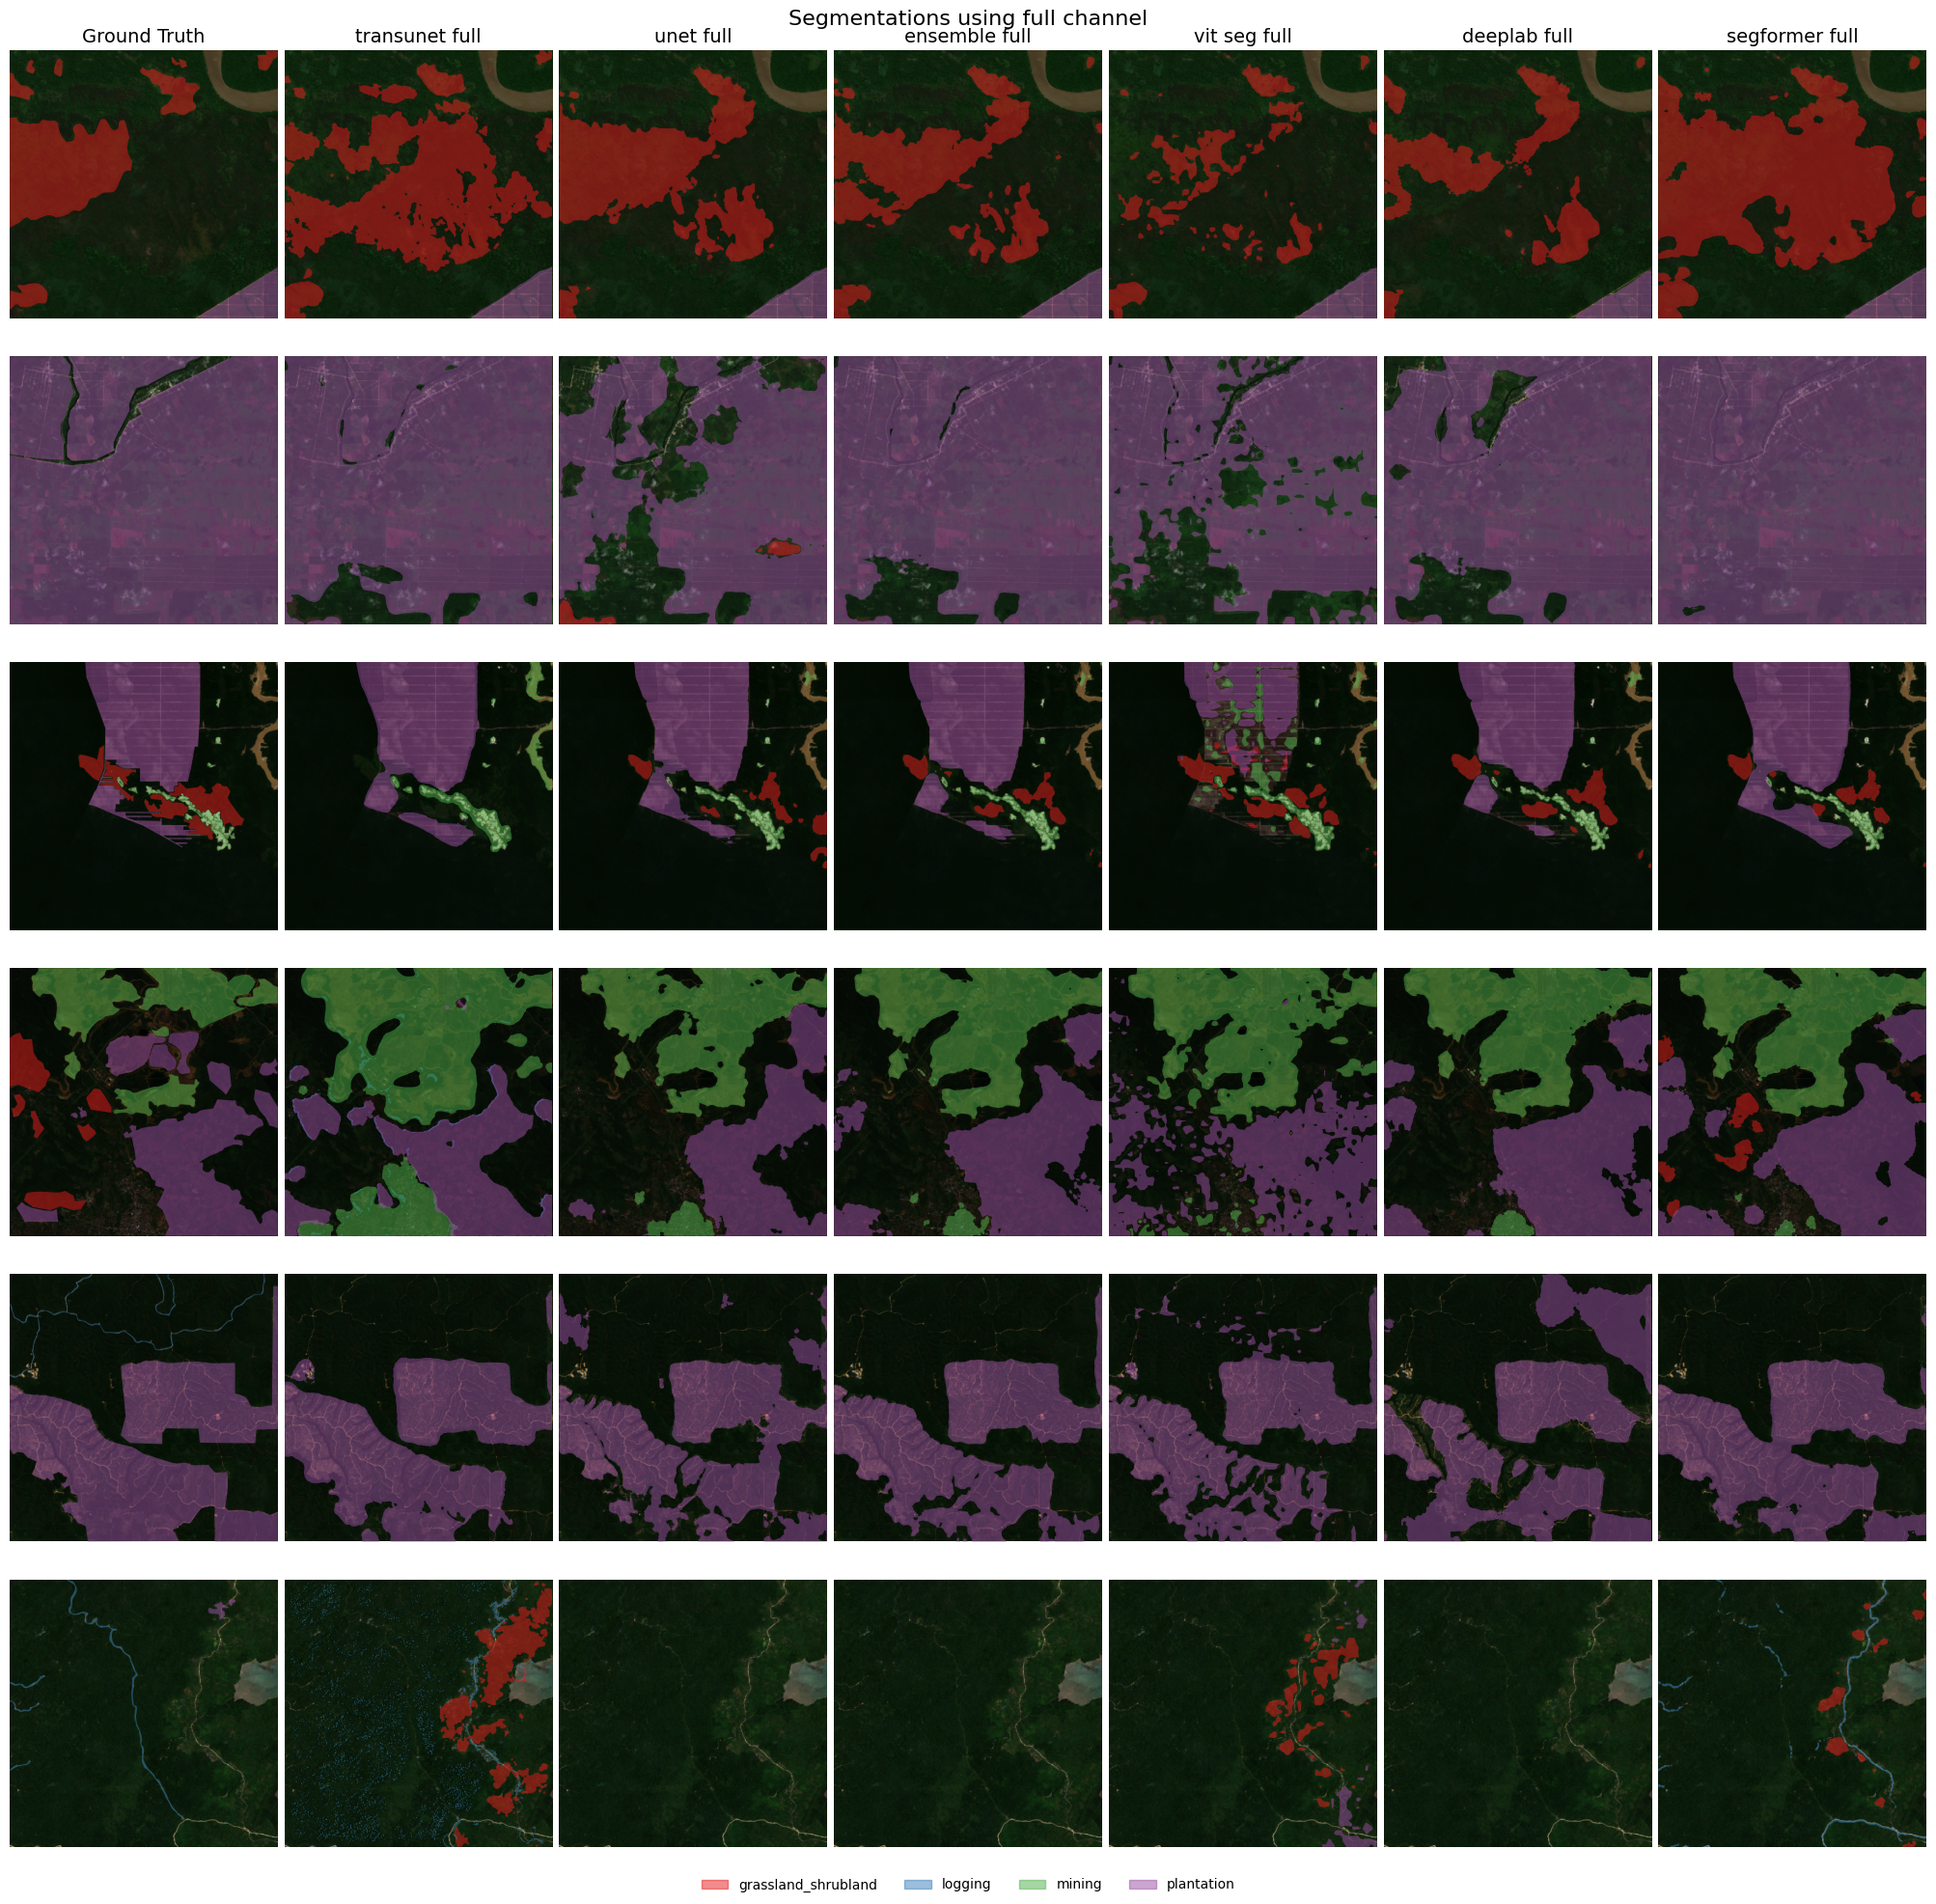

In [11]:
show_image_with_masks("train", [18, 24, 65, 82, 111, 167])

train_18.tif
train_24.tif
train_65.tif
train_82.tif
train_111.tif
train_167.tif


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:03<00:00,  9.73it/s]


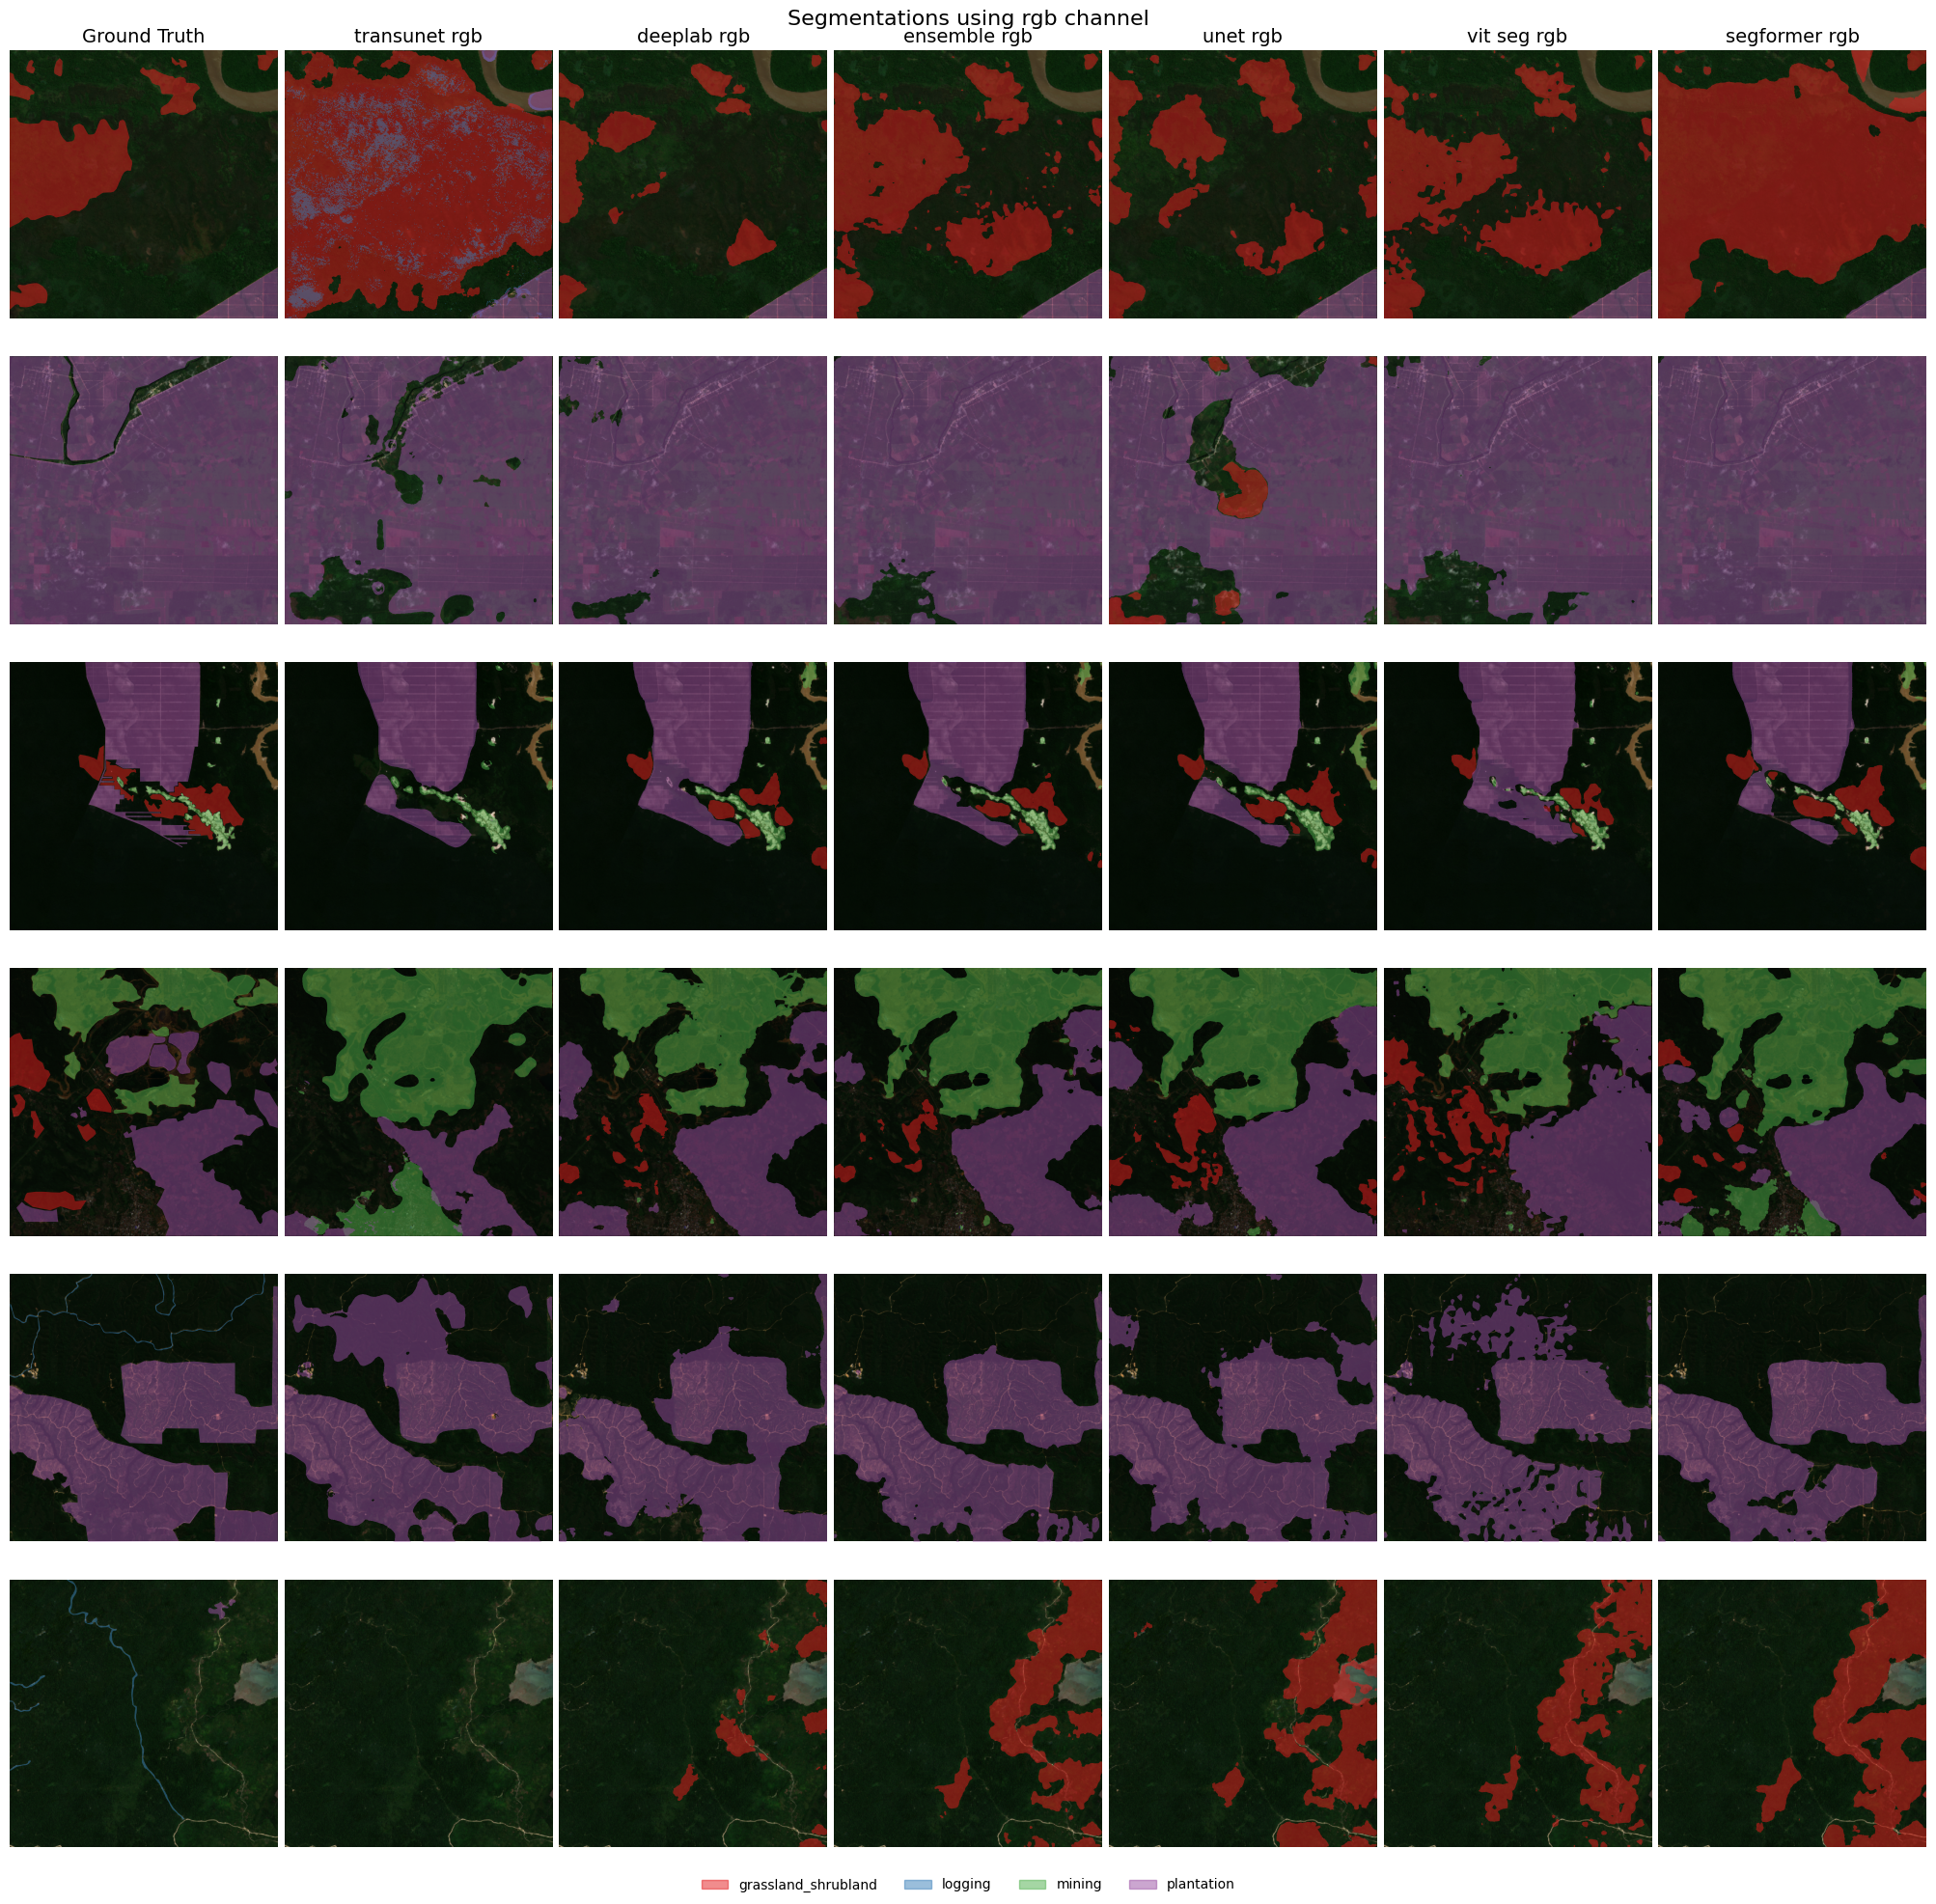

In [12]:
show_image_with_masks("train", [18, 24, 65, 82, 111, 167], "rgb")

In [ ]:
show_image_with_masks("val", 12)